# Beginner Tutorial - Part 1

## Introduction

The Beginner Tutorial Part 1 uses simulated (fake) data in order to keep things simple (see Part 2 for an application that uses real data). The tutorial covers the path from problem formulation, data preparation, model inference, and model analysis. The tutorial aims to teach the basic organization and mechanics of PsiZ, giving readers the background necessary to use PsiZ in their own projects. Some familiarity with TensorFlow is assumed. In order to provide a relatively gentle introduction, this tutorial bypasses some best practices and more advanced features.

```{note}
When a short-cut is taken, a callout box like this one highlights the best practice for real applications.
```

Big picture, PsiZ uses observable human behavior (such as similarity judgments) to infer psychological representations people use to perceive the world. While this tutorial uses fake stimuli, PsiZ is designed to model psychological representations of the real-world: such as images, audio, movies, words, odors, and text. After completing this tutorial you should have a good idea how to use PsiZ with your own data.

The tutorial is divided into five parts:

1. Problem Formulation
2. Model Construction
2. Data Preparation
4. Model Inference
5. Model Analysis

If you would like to run this notebook on your local machine, the file is available at [PsiZ's GitHub](https://github.com/psiz-org/psiz/blob/main/docs/src/beginner_tutorial/beginner_tutorial_part1.ipynb).

### Preliminaries

Start by importing packages and setting some environment variables. We also reduce TensorFlow's log output to a quieter setting.

```{note}
If you want to force execution to use a specific GPU, you can uncomment the lines marked with an `A`. If uncommented, the current setting will force execution to use "GPU 0". If you want to force *eager execution*, uncomment the line marked with a `B`. Eager execution is useful for debugging since it uses a non-optimized CPU mode that allows line-by-line state inspection. See the [TensorFlow Guide](https://www.tensorflow.org/guide/effective_tf2#debugging) for more information.
```

In [28]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import psiz

# Optional settings, see Note for explanation.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # A
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # A
# tf.config.run_functions_eagerly(True)  # B

## Problem Formulation

Imagine we are interested in understanding how the average person perceives a set of **30 stimuli**. These 30 stimuli could be almost anything: bird images, music tracks, beer flavors, flower fragrences, haikus.



We would like to assemble a cognitive map that reveals how the stimuli are arranged in psychological space. Being able to uncover the mental representations used by people has important applications in society. For example, it could help researchers understand how medical professionals recognize which skin lesions are life threatening. In turn, that knowledge could be leveraged to make medical training more efficient and less effortful.



### Solving with PsiZ

PsiZ uses formal models to understand mental representations. Since mental representations are not directly observable, we use statistical inference to identify the psychological representations that are most likely to explain observable behavior. A PsiZ model has two conceptual stages: (1) mapping a stimulus to a psychological representation (i.e., into a psychological space) and (2) mapping psychological representations to observable behavior. Each of these stages can be arbitrarily complex, but at a minimum we expect at least three model components: a *percept* module, *proximity* module, and *behavior* module ({numref}`fig-model-flow-1`). The percept module and proximity module work hand-in-hand to map a stimulus to a psychological representation. The behavior module details how the psychological representations yield the observed behavior. These modules are discussed in more detail below when we construct our first model.

```{figure} ../../img/model_flow_1task_v4.png
---
align: center
width: 350px
name: fig-model-flow-1
alt: "Stimulus and agent inputs feeding into large box denoting a cognitive model which outputs behavioral predictions. The large box has two smaller boxes denoting the two major modules: a percept and behavior module."
---
High-level organization of a generic PsiZ model. Stimulus and agent information is provided as input to a cognitive model. After internal processing, the model outputs the probability associated with different behavioral outcomes. Stimulus information includes details about *content* (e.g., information about the images shown on a trial). Agent information includes details about the human or computer agent (e.g., a personal identifier, experimental condition). The "wires" in the diagram show the flow of information through the model; from inputs, to percept module, to proximity module, to behavior module, to outputs. Agent (yellow) and stimulus (blue) information can influence the percept, proximity and behavior modules.
```

```{note}
Since a model can be run in generative mode, the model can be treated as *virtual subject*. For this reason, it is often preferable to use the more general term *agent*, which includes both human and machine.
```


### Choosing a Task

Many tasks can be used to ellicit obserable behavior, but a handful of tasks are particularly popular for probing psychological representations. Popular tasks include:

* **pairwise rating**: given two stimuli, rate the similarity of the two stimuli on a numerical scale (e.g., 1 to 7)
* **triplet similarity**: given 1 stimulus, choose which of two additional stimuli is most similar
* **odd-one-out**: given three images, select the image that doesn't belong
* **categorization**: given an image, provide the category label.

Some tasks will be better suited for certain stimuli. For example, if judging the similarity between odors, odors will need to be presented separately to prevent the odors from mixing; this makes sequential pairwise ratings a good task. In contrast, if using images as stimuli, multiple images can be shown simultaneously by tiling them on the display; allowing for a wider variety of tasks.

**In this tutorial, we use the triplet similarity task.** In a triplet similarity task, one stimulus serves as a *query* and two stimuli serve as *references*. The participant is tasked with selecting the reference that is most similarity to the query. A triplet similarity task is a special case of a more general *rank similarity* task. In a rank similarity task, a participant is shown `n_reference` references and must make `n_select` selections while also indicating the ranking of their selections. For the remainder of the tutorial we will refer to the triplet similarity task as a *2-rank-1* task.

### Model Hyperparameters

The simplest percept module is an embedding layer which maps a stimulus ID to a multidimensional representation (i.e., an embedding point). A common hyperparameter for embedding layers is the number of dimensions of the embedding space (what `tf.keras.layers.Embedding` calls `output_dim`). For this tutorial we will infer a **two-dimensional embedding** in order to keep the model simple and facilitate later visualization.

```{note}
When inferring an embedding in a real application, it is typically important to treat the dimensionality as a hyperparameter and select in an appropriate manner (e.g., via cross-validation).
```

### Choosing the Number of Trials

Each collected 2-rank-1 corresponds to a *triplet constraint*. Consider a trial with query stimulus $q$ and reference stimuli $a$ and $b$. If a participant selects $a$ as more similar, we can use a shorthand to denote the the triplet constraint $a > b | q$.

Inference is a search for a solution that best satisfies all the triplet constraints. In a multidimensional solution, stimuli that are judged as similar are placed close together in the multidimensional space and stimuli judged as dissimilar are placed far apart. We refer to this kind of representation as a *psychological embedding*.

If you give the same trial to different people, you may get different responses (i.e., between-subject variability). The same person might even give different reponses for the same trial, at different points in time (i.e., within-subject variability). The inference procedure will find the embedding that best satisfies all the (potentially noisy) triplet constraints.

It is difficult to predict how many trials will be necessary to obtain a high-quality embedding. Intuitively, you need enough triplet constraints to rule out incorrect solutions. There are three main factors that influence this amount:

1. More trials are necessary if the number of stimuli increases.
2. More trials are necessary if within- or between-subject agreement decreases.
3. The trial content selection strategy impacts how many trials are necessary.

This tutorial side-steps this issue by collecting a **pre-determined number of trials**.


```{note}
While predicting the necessary number of trials is challenging, it is relatively  straightforward to perform a post hoc evaluation that tests if a sufficient amount of data has been collected. For more details, see examples/rank/mle_1g.py and tutorials/beginner_tutorial_part_2
```

```{note}
In regards to different content selection strategies, using active learning to select trial content instead of randomly sampling trials can greatly reduce the number of trials necessary to achieve a stable embedding. See {cite}`Roads_Mozer_2019_BRM` and {cite}`Roads_Love_2021:CVPR` for details on performing active learning.
```

Collecting all of our problem specifications gives us the following variables:

In [29]:
# Number of stimuli.
n_stimuli = 30

# Settings defining the 2-rank-1 (triplet) similarity task.
n_reference = 2
n_select = 1

# Hyperparameter choices.
n_dim = 2

# Number of trials to use.
n_trial = 3000


With the general problem parameters specified, we can dive into constructing an appropriate model

## Model Construction

A PsiZ model contains at least three model components ({numref}`fig-model_2rank1_example`). These components are intentionally denoted as *modules* because each can be substituted with arbitrarily complex variants.

1. A *percept* module describes the data structure used to model a mental representation. For example, a multidimensioanl vector, set, or graph.
2. A *proximity* module describes how proximity is computed between two psychological representations. For example, this could be Euclidean distance, cosine similarity, or something more sophisticated. The term *proximity* is intentional, because depending on the setup a research may prefer working with dissimilarity values or similarity values. Together, a percept module and proximity module define a psychological space.
3. A *behavior* module describes how the perceived stimuli yield the observed task behaviour. A given model may have more than one behavior module in order to predict multiple types of behavior.

```{figure} ../../img/model_2rank1_example_v5.png
---
align: center
name: fig-model_2rank1_example
alt: "A flow diagram showing inputs feeding to an embedding percept module, a proximity module, a 2-rank-1 similarity behavior module, and then producing behavioral outputs."
---
A diagram of the generative model used in this tutorial. The diagram is simplified by assuming there are only 10 stimuli, although the tutorial uses 30 stimuli.
```

```{note}
In TensorFlow, a *layer* is the name used for an abstract building block of a model. When using TensorFlow it is best practice to assemble your models from layers. One of the main benefits of PsiZ is the set of layers it provides.
```

### Percept Module

The percept module formalizes the notion of a mental representation by adopting a particular data structure. In this tutorial, the percept module is a *population-level* embedding layer where each perceived stimulus is modeled as a multidimensional vector.

```{note}
A population-level layer means that the free parameters are fit to all of the data and ignore agent membership.
```

```
percept = tf.keras.layers.Embedding(
    n_stimuli + 1,
    n_dim,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.RandomNormal(stddev=.17)
)
```

The embedding coordinates are assigned to the layer variable `percept`. If we assume that the embedding has $N$ stimuli and $D$ dimensions, then the `percept` layer has a learnable weight matrix $\bm{Z} \in \mathbb{R}^{N \times D}$. The weight matrix $\bm{Z}$ behaves like a lookup table during a forward pass of the model. The weight matrix $\bm{Z}$ is randomly initialized according to a Normal distribution.

For example, consider the case where a 2-rank-1 trial is presented to the model (the case shown in {numref}`fig-model_2rank1_example`). If stimulus `9` is the query and stimuli `1` and `7` are references (i.e., $\bm{x}_i = \left[9, 1, 7 \right]$), we would grab the corresponding rows of $\bm{Z}$: $\bm{z}_9$, $\bm{z}_1$, and $\bm{z}_7$. Each row, or vector, represents the corresponding $d$-dimensional coordinates of stimuli `9`, `1`, and `7`.

We use the `mask_zero` argument to let the model know it should ignore `0` placeholder integers. While ignoring `0` is not necessary in this tutorial, we do it to stay consistent with other tutorials and examples where it is necessary.

```{note}
If you want to model individual differences or differences between experimental conditions, you could use a more sophisticated percept module. For example, you could use an implementation based on the classic idea of *attention weights* (see [`examples/rank/mle_3g.py`](https://github.com/psiz-org/psiz/blob/main/examples/rank/mle_3g.py)) or use more than one embedding layer.
```

### Proximity Module

The proximity module formalizes how an agent perceives similarity (or dissimilarity) between two stimuli. In this tutorial, the proxmity module is a population-level layer that computes a nonlinear transformation of Euclidean distance.

```
proximity = psiz.keras.layers.Minkowski(
    rho_initializer=tf.keras.initializers.Constant(2.),
    w_initializer=tf.keras.initializers.Constant(1.),
    activation=psiz.keras.layers.ExponentialSimilarity(
        beta_initializer=tf.keras.initializers.Constant(10.),
        tau_initializer=tf.keras.initializers.Constant(1.),
        gamma_initializer=tf.keras.initializers.Constant(0.),
        trainable=False,
    ),
    trainable=False
)
```

The proximity layer is assigned to the variable `proximity`. The proximity layer `psiz.keras.layers.Minkowski` is itself composed of two steps: the core Minkowski distance computation and an (optional) transformation of the distance value (`psiz.keras.layers.ExponentialSimilarity`). It is worth noting that both of these steps are parameterized and the parameters can be learned from the data. To keep the tutorial simple, all of the proximity parameters are set to sensible values and made untrainable via the `trainable=False` argument.

The `Minkowski` layer computes the weighted Minkowski distance between two vectors:
```{math}
:label: eq:minkowski
\mathrm{d} \left( \bm{z}_i, \bm{z}_j \right) = \| \bm{z}_i - \bm{z}_j\|_{\rho, \bm{w}} = \left[ \sum^{D}_{d} w_{d} \left( z_{i,d} - z_{j,d}\right)^{\rho} \right]^{\frac{1}{\rho}}.
```
The distance function parameters are set to $\rho=2$ and $\bm{w}=\bm{1}$, which yields the standard Euclidean distance function. The `ExponentialSimilarity` layer takes the distance and applies a non-linear mapping:
```{math}
:label: eq:similarity
\mathrm{s} \left( \bm{z}_i, \bm{z}_j \right) = \mathrm{exp}\left(-\beta \mathrm{d}\left( \bm{z}_i, \bm{z}_j \right)^{\tau} \right) + \gamma.
```
The activation function parameters are set to $\beta=10$, $\gamma=0$, and $\tau=1$; yielding similarity that decays exponentially as distance increases.

The psychological theory motivating this proximity function can be found elsewhere {cite}`Jones_Love_Maddox_2006,Jones_Maddox_Love_2006,Nosofsky_1986,Roads_Mozer_2019_BRM,Shepard_1987`, but it is worth noting that many other proximity functions are possible. Decomposing the proximity function into two steps makes it easy to explore different variants. For example, one might want to try a heavy-tailed activation function that is popular in the machine learning literature {cite}`vanderMaaten_2012:MLSP` or use a non-Minkowski distance function.

Continuing with our 2-rank-1 example, the coordinates ($\bm{z}_9$, $\bm{z}_1$, $\bm{z}_9$) are used in the proximity function to compute similarity. A 2-rank-1 trial involves computing two similarity relations: $\mathrm{s}\left( \bm{z}_9, \bm{z}_1 \right)$ and $\mathrm{s}\left( \bm{z}_9, \bm{z}_1 \right)$.


### Behavior Module

A behavior module maps psychological representations to an observed behavior. In this tutorial, there is one population-level behavior module that models 2-rank-1 (i.e., triplet) similarity judgments. The behavioral outcomes of a 2-rank-1 trial are computed using a `SoftRank` layer.

```
soft_2rank1 = psiz.keras.layers.SoftRank(n_select=n_select)
```

The layer name is partially inspired by the naming of a "softmax" operation. Instead of outputing probabilites associated with particular items, it outputs probabilities associated with different ranking outcomes. The unique ranking outcomes are determined by the number of options and the number of selections(`n_select`). The number of options is inferred from the input shape. It is therefore a good idea to name the layer in a way that makes its intended use clear (e.g., `soft_2rank1`). Outcomes probabilities are computed using Luce's choice rule {cite}`Luce_1959`. In the case of a 2-rank-1 trial, a reference is selected in proportion to its similarity with the query. The probability of selecting reference `a` instead of reference `b` is:
```{math}
:label: eq:2-rank-1
\mathrm{P} \left( \mathcal{D}_{i} = \left[q, a, b \right] \right) = \frac{\mathrm{s} \left( \bm{z}_q, \bm{z}_a \right)}{\mathrm{s} \left( \bm{z}_q, \bm{z}_a \right) + \mathrm{s} \left( \bm{z}_q, \bm{z}_b \right)}.
```

Continuing with the example introduced above, given query `9`, the probabilty of selecting reference `1` (instead of `7`) is:
```{math}
:label: eq:2-rank-1-a
\mathrm{P} \left( \mathcal{D}_{i} = \left[9, 1, 7 \right] \right) = \frac{\mathrm{s} \left( \bm{z}_9, \bm{z}_1 \right)}{\mathrm{s} \left( \bm{z}_9, \bm{z}_1 \right) + \mathrm{s} \left( \bm{z}_9, \bm{z}_7 \right)}.
```

Using this equation you can compute the probabilities associated with all possible outcomes. For a 2-rank-1 trial there are only two possible outcomes. If one needs to run a model in generative mode, these probabilities can be converted to a single outcome by sampling from the probabilities.

### Putting It All Together

The last step is to package all of these pieces up inside a Keras `Model`. To make it easy to build and compile multiple models, we wrap the construction code inside a `build_rank_model` function. The compile step uses categorical crossentropy for the loss (i.e., maximum likelihood estimation).

```{note}
Maximum likelihood estimation (MLE) is a convenient method, but is limited by the fact it lacks a direct read-out of confidence (i.e., uncertainty). In situations where you also need to know how certain an estimate is, you could use an approach like variational inference (see [`examples/rank/vi_1g.py`](https://github.com/psiz-org/psiz/blob/main/examples/rank/vi_1g.py)).
```

In [30]:
class RankModel(tf.keras.Model):
    """A Keras model of ranked similarity judgments."""

    def __init__(self, percept=None, proximity=None, **kwargs):
        """Initialize."""
        super(RankModel, self).__init__(**kwargs)
        # NOTE: The `stimuli_axis` is the axis` used to store indices of
        # all the quries and references.
        self.stimuli_axis = 1

        self.percept = percept
        self.proximity = proximity

        # Create a behavior module for the 2-rank-1 similarity task.
        self.soft_2rank1 = psiz.keras.layers.SoftRank(n_select=n_select)


    def call(self, inputs):
        """Call."""
        z = self.percept(inputs["given2rank1_stimulus_set"])
        z_q, z_r = tf.split(z, [1, 2], self.stimuli_axis)
        s = self.proximity([z_q, z_r])
        return self.soft_2rank1(s)
    
    def get_config(self):
        config = super(RankModel, self).get_config()
        return config


def build_rank_model(n_stimuli, n_reference, n_select, n_dim):
    """Build ranked similarity model.

    Args:
        n_stimuli: Integer indicating the number of stimuli in the
            embedding.
        n_reference: Integer indicating the number of references in
            the ranked similarity judgment.
        n_select: Integer indicating the number of selections in the
            ranked similarity judgment.
        n_dim: Integer indicating the dimensionality of the embedding.

    Returns:
        model: A compiled Keras model.

    """
    # Create a psychological embedding layer that contains free parameters
    # representing the psychological coordinates of the stimuli.
    percept = tf.keras.layers.Embedding(
        n_stimuli + 1,
        n_dim,
        mask_zero=True,
        embeddings_initializer=tf.keras.initializers.RandomNormal(stddev=.17)
    )

    # Create a proximity layer that computes the similarity between
    # coordinates in psychological space.
    proximity = psiz.keras.layers.Minkowski(
        rho_initializer=tf.keras.initializers.Constant(2.),
        w_initializer=tf.keras.initializers.Constant(1.),
        activation=psiz.keras.layers.ExponentialSimilarity(
            beta_initializer=tf.keras.initializers.Constant(10.),
            tau_initializer=tf.keras.initializers.Constant(1.),
            gamma_initializer=tf.keras.initializers.Constant(0.),
            trainable=False,
        ),
        trainable=False
    )
    
    # Pass component layers to the subclassed Keras model.
    model = RankModel(percept=percept, proximity=proximity)

    # Compile the model using categorical crossentropy for the loss and
    # a popular gradient decent optimizer.
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
    )

    return model

## Data Preparation

Since we are using simulated data, our data preparation pipeline will include a virtual agent. We will treat the virtual agent as our *ground truth* model. Our hope is that the *inferred* model (which is blind to the embedding coordinates of the ground truth model) learns an embedding that   matches the ground truth model.

We will start by creating our virtual agent (ground truth model) that outputs 2-rank-1 predictions.

In [31]:
virtual_agent_2rank1 = build_rank_model(
    n_stimuli, n_reference, n_select, n_dim
)

Next we generate a random sample of 2-rank-1 trial content and format as a `tf.data.Dataset` object.

In [32]:
# Generate a random set of trials.
rng = np.random.default_rng()
eligibile_indices = np.arange(n_stimuli) + 1
p = np.ones_like(eligibile_indices) / len(eligibile_indices)
stimulus_set = psiz.utils.choice_wo_replace(
    eligibile_indices, (n_trial, 3), p, rng=rng
)
content = psiz.data.Rank(stimulus_set, n_select=1)
pds = psiz.data.Dataset([content])
tfds_content = pds.export(export_format='tfds')

```{note}
You may have noticed that the stimulus IDs begin at `1`, not `0`. This ties back to our choice to use `mask_zero=True`.
```

```{note}
Since we are using the TensorFlow ecosystem, we convert the data objects into `tf.data.Dataset` objects. This allows us to seamlessly exploit TF's flexible data processing pipeline. You can learn more by going to [TF's tf.data.Dataset documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).
```

The last data preparation step is to specify our batch settings.

```{note}
The `batch_size` is typically chosen to be a power of 2 since this tends to be more efficient for reasons related to computer architecture. In memory-intensive applications, one typically picks the largest possible power of 2 such that the memory footprint of the batch will still fit on the GPUs/TPUs being used. However, you do not want a batch size that is so large that there is only one batch because multiple batches adds noise that helps gradient decent avoid local optimums (an important theoretical properity of stochastic gradient decent). In this application, our memory-footprint is small and a wide range of values work well.
```

We then feed the trial content to the virtual agent and simulate trial behavior.

In [33]:
batch_size = 128

# Simulate similarity judgments and append outcomes to dataset.
depth = content.n_outcome

def simulate_agent(x):
    # Compute probability associated with all possible outcomes (2 outcomes).
    outcome_probs = virtual_agent_2rank1(x)
    # Sample an outcome based on probabilities.
    outcome_distribution = tfp.distributions.Categorical(
        probs=outcome_probs
    )
    outcome_idx = outcome_distribution.sample()
    # Convert sampled outcome into a one-hot vector.
    outcome_one_hot = tf.one_hot(outcome_idx, depth)
    return outcome_one_hot

tfds_content = tfds_content.batch(batch_size=batch_size, drop_remainder=False)
tfds_all = tfds_content.map(lambda x: (x, simulate_agent(x))).cache()
tfds_all = tfds_all.unbatch()

In general, when fitting a model we are primarily intersted in how well a model generalizes to **new** data and therefore want to prevent overfitting. To achive this goal we follow standard practice and partition the data into a train, validation, and test set. In this tutorial we use an 80:10:10 split.

In [34]:
# Partition the data into 80% train, 10% validation and 10% test set.
n_trial_train = int(np.floor(0.8 * n_trial))
n_trial_val = int(np.floor(0.1 * n_trial))

tfds_train = tfds_all.take(n_trial_train).cache()
tfds_valtest = tfds_all.skip(n_trial_train)
tfds_val = tfds_valtest.take(n_trial_val).cache()
tfds_test = tfds_valtest.skip(n_trial_val).cache()

tfds_train = tfds_train.shuffle(
    buffer_size=n_trial_train, reshuffle_each_iteration=True
).batch(
    batch_size, drop_remainder=False
)
tfds_val = tfds_val.batch(
    batch_size, drop_remainder=False
)
tfds_test = tfds_test.batch(
    batch_size, drop_remainder=False
)

With our data ready, we can move on to inferring a model.

## Model Inference

With our data ready, we create a fresh model that will serve as our *inferred* model.

In [35]:
inferred_model = build_rank_model(n_stimuli, n_reference, n_select, n_dim)

We will train our models until validation loss stops improving. This is implemented using an `EarlyStopping` callback.

The number of epochs (`epochs`) is set to a sufficiently high number that the model reaches the early stopping criteria before the maximum number of epochs is exceeded. For our loss, we use categorical crossentropy because we are computing the probability of all possible outcomes (a categorical output).

```{note}
Since PsiZ carefully adheres to TensorFlow and Keras idioms, we can easily use features like Callbacks without any headaches. See TF documentation for more on [TF Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).
```

```{note}
Inference can take a few minutes to run depending on the hardware you are using.
```

In [36]:
def train_routine(model, tfds_train, tfds_val, tfds_test):
    """Run training routine.
    
    Args:
        model: A PsiZ model.
        tfds_train: A TF Dataset object of train data.
        tfds_val: A TF Dataset object of validation data.
        tfds_test: A TF Dataset object of test data.

    Returns:
        metrics: A dictionary of metrics.

    """
    epochs = 3000

    # Define an early stopping callback.
    early_stop = tf.keras.callbacks.EarlyStopping(
        'val_loss', patience=30, mode='min', restore_best_weights=True
    )
    callbacks = [early_stop]

    model.fit(
        x=tfds_train, validation_data=tfds_val, epochs=epochs,
        callbacks=callbacks, verbose=0
    )

    train_results = model.evaluate(
        tfds_train, verbose=0, return_dict=True
    )
    val_results = model.evaluate(
        tfds_val, verbose=0, return_dict=True
    )
    test_results = model.evaluate(
        tfds_test, verbose=0, return_dict=True
    )

    print(
        'Metrics\n'
        '          | loss  | acc.  |\n'
        '    train | {0:.3f} | {1:.3f} |\n'
        '    val   | {2:.3f} | {3:.3f} |\n'
        '    test  | {4:.3f} | {5:.3f} |\n'.format(
            train_results['loss'],
            train_results['accuracy'],
            val_results['loss'],
            val_results['accuracy'],
            test_results['loss'],
            test_results['accuracy'],
        )
    )
    results = {
        'train': train_results,
        'val': val_results,
        'test': test_results,
    }
    return results

print('Inferred Model')
results = train_routine(inferred_model, tfds_train, tfds_val, tfds_test)

Inferred Model
Metrics
          | loss  | acc.  |
    train | 0.440 | 0.785 |
    val   | 0.499 | 0.777 |
    test  | 0.501 | 0.763 |



The results from training reveal reasonable agreement between the train, validation, and test set. Note that the accuracy is less that `1.0`, but greter than chance (`0.5`).  The optimization process attempts to find the solution that satisfies as many triplet constraints as possible. Since the agent data was generated using a stochastic process, some of the simulated behavior is inconsistent. Inconsistent data is a common occurrence when using data from multiple people.

## Model Analysis

Model analysis is typically a multi-pronged approach. We will start by visualizing the embeddings and then detail a popular quantitative approach for comparing embeddings.

### Embedding Visualization

One way to explore the quality of the learned model is to visualize the entire embedding. While this is not always possible with high dimensional embeddings, our 2D embeddings are easy to visualize. We will use `matplotlib` and color code the 30 stimuli.

In [37]:
import matplotlib
import numpy as np

def color_styling(n_stimuli):
    """Hard-coded styling.
    
    First ten stimuli get colorful styling, remaining stimuli are gray.

    Args:
        n_stimuli: Integer indicating the number of stimuli.

    Returns:
        color_arr: An array of colors.

    """
    # Define colors.
    n_color = 10
    cmap = matplotlib.cm.get_cmap('gist_ncar')
    norm = matplotlib.colors.Normalize(vmin=0., vmax=n_color)
    color_arr = cmap(norm(range(n_color)))

    n_gray = n_stimuli - n_color
    gray_arr = .7 * np.ones([n_gray, 4])
    gray_arr[:, 3] = 1.

    color_arr =  np.vstack([color_arr, gray_arr])
    return color_arr

color_arr = color_styling(n_stimuli)

With our styling defined, we can create a visualization for each model.

[]

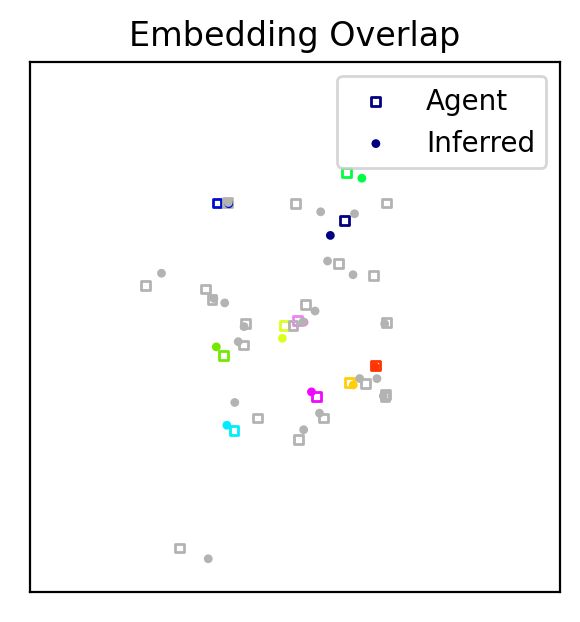

In [38]:
import matplotlib.pyplot as plt

def plot_embedding_overlap(ax, agent, inferred, color_arr):
    """Plot embedding.
    
    Args:
        ax: A Matplotlib axes object.
        agent: A Keras model.
        inferred: A Keras model.
        class_arr: An array of colors.

    """
    # Hardcoded values.
    s = 10  # Size of plot markers.
    scatter_padding = 1.2  # Padding around embedding scatter points.

    loc_agent = process_coordinates(agent)
    loc_inferred = process_coordinates(inferred)

    # Apply Procrustes transformation since our embeddings are rotation
    # invariant.
    r = psiz.utils.procrustes_rotation(
        loc_inferred, loc_agent, scale=True
    )
    loc_inferred = np.matmul(loc_inferred, r)

    # Determine embedding limits of family.
    z_max = scatter_padding * np.max(np.abs(loc_agent))
    z_limits = np.array([-z_max, z_max])

    # Draw embedding points.
    ax.scatter(
        loc_agent[:, 0],
        loc_agent[:, 1],
        s=s,
        c='none',
        marker='s',
        edgecolors=color_arr,
        label='Agent'
    )
    ax.scatter(
        loc_inferred[:, 0],
        loc_inferred[:, 1],
        s=s,
        c=color_arr,
        marker='o',
        edgecolors='none',
        label='Inferred'
    )
    ax.set_xlim(z_limits)
    ax.set_ylim(z_limits)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])


def process_coordinates(model):
    # Grab embedding coordinates.
    loc = model.percept.embeddings.numpy()
    if model.percept.mask_zero:
        # Drop placeholder stimulus.
        loc = loc[1:]

    # Center coordinates for Procrustes and plotting.
    loc = loc - np.mean(loc, axis=0, keepdims=True)

    return loc


# Create visual of two models.
fig = plt.figure(figsize=(3, 4), dpi=200)
gs = fig.add_gridspec(1, 1)

ax = fig.add_subplot(gs[0, 0])
plot_embedding_overlap(
    ax, virtual_agent_2rank1, inferred_model, color_arr
)
ax.set_title('Embedding Overlap')
ax.legend()

gs.tight_layout(fig)
plt.plot()

### What about the differences between the two embeddings?

Some of the coordinates for the inferred embedding do not overlap with the corresponding coordinates of the virtual agent. We have already confirmed that the two models have similar losses, so what's going on? While this difference may seem meaningful from the perspective of L2 (Eulcidean) distance, it is important to remember that similarity (not distance) is the critical quantity in these models. In these models, similarity decays exponentially with increasing distance. This means that two stimuli that are moderately far apart and extremely far apart will both have a small similarity. As a consequence there are a large number of equally good solutions for embedding dissimilar items. In contrast, the relatively similar items constrain which solutions are viable. This flexibility means that visual inspection is fine for initial exploration, but it is not a great way to *compare* embeddings. To make comparisons, we need an alternative strategy.

### Second-Order Isomporphism

Embedding coordinate visualizations yield figures that provide a general picture of the learned solution. But coordinates only tell part of the story. It is more important that the emeddings correctly model pairwise similarity between items. Since similarity is often a non-linear function, focusing on Euclidean distances between coordinates can be misleading. A summary of similarity can be obtained by assembling a pairwise similarity matrix $\mathbf{s}$, where the matrix element $s_{ij}$ contains the computed similarity between stimulus $i$ and stimulus $j$. "Unrolling" (i.e., reshaping) the matrix into a one dimensional array allows us to easily compare two pairwise similarity matrices.

```{note}
Depending on the proximity function, some elements of the matrix elements should be omitted from the comparison. For instance, if self-similarity (i.e., diagonal ) values are uninformative, they should be excluded since they may artificially inflate the comparison. In this tutorial, self-similarity is always `1` so we exclude the diagonal elements. If the proximity function is symmetric (`s(z_0,z_1) = s(z_1, z_0)`), it is not necessary to compute both $s_{ij}$ and $s_{ji}. Instead one can compute just the upper (or lower) triangular portion of the similarity matrix. Since our similarity function is symmetric we will only compute the upper triangular portion.
```

A popular method of comparison is to compute the Pearson correlation between two unrolled similarity matrices. This method of comparison allows us to evaluate the extent that models exhibit *meaningful* differences. This kind of analysis has been around a long time in psychology. For example, Sheperd framed this analysis as focusing on second-order isomorphism (similarity matrix equivalency) rather than focusing on first-order isomorphism (coordinate equivalency) {cite}`Shepard_Chipman_1970`. Today, cognitive scientists often refer to this kind of analysis as representational similarity analysis (RSA) {cite}`Kriegeskorte_Mur_Bandettini_2008`.

```{note}
There are multiple strategies for comparing similarity matrices, such as canonical correlation analysis (CCA). Each approach has its strengths and weaknesses. Pearson correlation provides a simple, but intuitive strategy. In a research setting, the optimal comparison strategy will depend on the details of the project.
```

In general, computing a pairwise similarity matrix is expensive in terms of computational and storage costs. While the costs are minimal for this small stimulus set, PsiZ is designed to scale to large problems. For this reason, pairwise similarity is computed using a batch strategy. We start by creating a dataset of index pairs via the `psiz.data.Rate` object.

In [39]:
# Assemble a TF Dataset of pairwise indices that will be used to compute
# "unrolled" similarity matrices. Note that we start the indices at `1`
# since we are not interested in computing the similarity of the
# placeholder `0` index.
content_pairs = psiz.data.Rate(
    psiz.utils.pairwise_indices(np.arange(n_stimuli) + 1, elements='upper')
)
# NOTE: We include an placeholder "target" component in dataset tuple to
# satisfy the assumptions of `predict` method.
dummy_outcome = psiz.data.Continuous(np.ones([content_pairs.n_sample, 1]))
tfds_pairs = psiz.data.Dataset(
    [content_pairs, dummy_outcome]
).export().batch(batch_size, drop_remainder=False)

Next we create a Keras model that predicts pairwise similarity and instantiate an instance for the virtual agent and inferred model.

In [40]:
class PairwiseModel(tf.keras.Model):
    """A model that outputs similarity between input pairs."""

    def __init__(self, percept=None, proximity=None, **kwargs):
        """Initialize."""
        super(PairwiseModel, self).__init__(**kwargs)
        self.percept = percept
        self.proximity = proximity

    def call(self, inputs):
        """Call."""
        stimuli_axis = 1
        z = self.percept(inputs['rate2_stimulus_set'])
        z_0 = tf.gather(z, indices=tf.constant(0), axis=stimuli_axis)
        z_1 = tf.gather(z, indices=tf.constant(1), axis=stimuli_axis)
        return self.proximity([z_0, z_1])
    
    def get_config(self):
        config = super(PairwiseModel, self).get_config()
        return config


virtual_agent_pairwise = PairwiseModel(
    percept=virtual_agent_2rank1.percept,
    proximity=virtual_agent_2rank1.proximity
)
inferred_pairwise = PairwiseModel(
    percept=inferred_model.percept,
    proximity=inferred_model.proximity
)

After computing the pairwise similarities for both the `virtual_agent` and `inferred_model`, we compute the Pearson correlation between the two sets of values.

In [41]:
from scipy.stats import pearsonr

# The pairwise similarities for the virtual agent.
virtual_agent_similarity = virtual_agent_pairwise.predict(tfds_pairs)
# The pairwsie similarities for the inferred model.
inferred_similarity = inferred_pairwise.predict(tfds_pairs)

rho, _ = pearsonr(virtual_agent_similarity, inferred_similarity)
print('Pearson rho: {0:.2f}'.format(rho))

4/4 [==============================] - 0s 2ms/step
Pearson rho: 0.96


The high Pearson correlation reveals that what initially seemed like a notable difference from the perspective of absolute coordinate position and Euclidean distance, is only a minor difference from the perspective of pairwise similarity. The high correlation value also suggests that the embedding solution is stable and that a sufficient amount of data has been used to train the model.

```{note}
To decide if an embedding is stable, you can use the conservative heuristic of a Pearson correlation of 0.95 or greater. Depending on your research goals, you may need to use a lower or higher threshold. Aiming for a correlation of 1.00 is typically impractical since there are diminishing returns to data collection. If a high Pearson correlation is necessary, you should strongly consider more sophisticated data collection strategies, such as active learning. Strategies like active learning help make the most of your data collection budget.
```

## Summary

The Beginner Tutorial introduced a number of topics:
* The general problem PsiZ is designed to solve
* Constructing a basic embedding model.
* Data prepartion
* Model inference
* Visualizing an embedding
* Checking second-order isomorphism.

The Beginner Tutorial employed a number of simplifications to keep the focus on the general organization of PsiZ and avoid clutter from optional features. To learn about additional features, explore the remaining tutorials and example scripts.

## Exercises

1. Using only 10% of the data, train a new model. Perform an RSA analysis between the new inferred model amd the virtual agent. What does the RSA analysis suggest? Is 10% of the data sufficient to achieve a stable embedding?
2. When instantiating the virtual agent, use `n_dim=3`. Now train three new models: one that uses `n_dim=2`, `n_dim=3`, and `n_dim=4`. Which of the new models has a better test loss? What does this mean from the perspective of selecting a model with the best generalization performance?


<!-- ```{bibliography}
:style: plain
``` -->